In [ ]:
# Importing necessary libraries
# Numpy and Pandas are used for numerical operations and data handling respectively
# Seaborn and Matplotlib are used for visualization
# TensorFlow/Keras is used for building the deep learning model
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import itertools
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Setting up file paths for image dataset
# Loop through each folder in the data directory to get file paths and labels
data_dir = 'lung_image_sets'

filepaths = []
labels = []

classes = os.listdir(data_dir)
for fold in classes:
    foldpath = os.path.join(data_dir, fold)

    if os.path.isdir(foldpath):
        for file in os.listdir(foldpath):
            filepaths.append(os.path.join(foldpath, file))
            labels.append(fold)

df = pd.DataFrame({'filepaths': filepaths, 'labels': labels})

In [ ]:
# Displaying the DataFrame to preview the data
df

filepaths    labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  lung_aca
1      /kaggle/input/lung-and-colon-cancer-histopatho...  lung_aca
2      /kaggle/input/lung-and-colon-cancer-histopatho...  lung_aca
3      /kaggle/input/lung-and-colon-cancer-histopatho...  lung_aca
4      /kaggle/input/lung-and-colon-cancer-histopatho...  lung_aca
...                                                  ...       ...
14995  /kaggle/input/lung-and-colon-cancer-histopatho...    lung_n
14996  /kaggle/input/lung-and-colon-cancer-histopatho...    lung_n
14997  /kaggle/input/lung-and-colon-cancer-histopatho...    lung_n
14998  /kaggle/input/lung-and-colon-cancer-histopatho...    lung_n
14999  /kaggle/input/lung-and-colon-cancer-histopatho...    lung_n

[15000 rows x 2 columns]

In [ ]:
# Function to rename label names for better readability
# This helps in transforming the label names from abbreviations to full descriptive names
def change_label_names(df, column_name):
    index = {'lung_aca': 'Lung_adenocarcinoma', 'lung_n': 'Lung_benign_tissue', 'lung_scc': 'Lung squamous_cell_carcinoma'}
    df[column_name] = df[column_name].replace(index)

In [ ]:
# Displaying the DataFrame to preview the data
change_label_names(df, 'labels')
df

filepaths               labels
0      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
1      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
2      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
3      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
4      /kaggle/input/lung-and-colon-cancer-histopatho...  Lung_adenocarcinoma
...                                                  ...                  ...
14995  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14996  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14997  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14998  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue
14999  /kaggle/input/lung-and-colon-cancer-histopatho...   Lung_benign_tissue

[15000 rows x 2 columns]

In [ ]:
# Splitting the dataset into training, validation, and test sets
# 80% of data for training, 10% for validation, and 10% for testing
train_df, dummy_df=train_test_split(df, train_size=0.8, shuffle=True, random_state=123)
test_df, valid_df=train_test_split(dummy_df, train_size=0.5, shuffle=True, random_state=123)

In [ ]:
# Setting up data generators for training, validation, and testing
# This includes defining batch size, image size, and augmentation strategies
batch_size = 64
img_size = (224, 224)
img_shape = (img_size[0], img_size[1], 3)

tr_gen = ImageDataGenerator()
ts_gen = ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                       color_mode='rgb', shuffle= True, batch_size=batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                      color_mode='rgb', shuffle=True, batch_size=batch_size)

test_gen = ts_gen.flow_from_dataframe(test_df, x_col='filepaths', y_col='labels', target_size=img_size, class_mode='categorical',
                                     color_mode='rgb', shuffle=False, batch_size=batch_size)

Found 12000 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.
Found 1500 validated image filenames belonging to 3 classes.


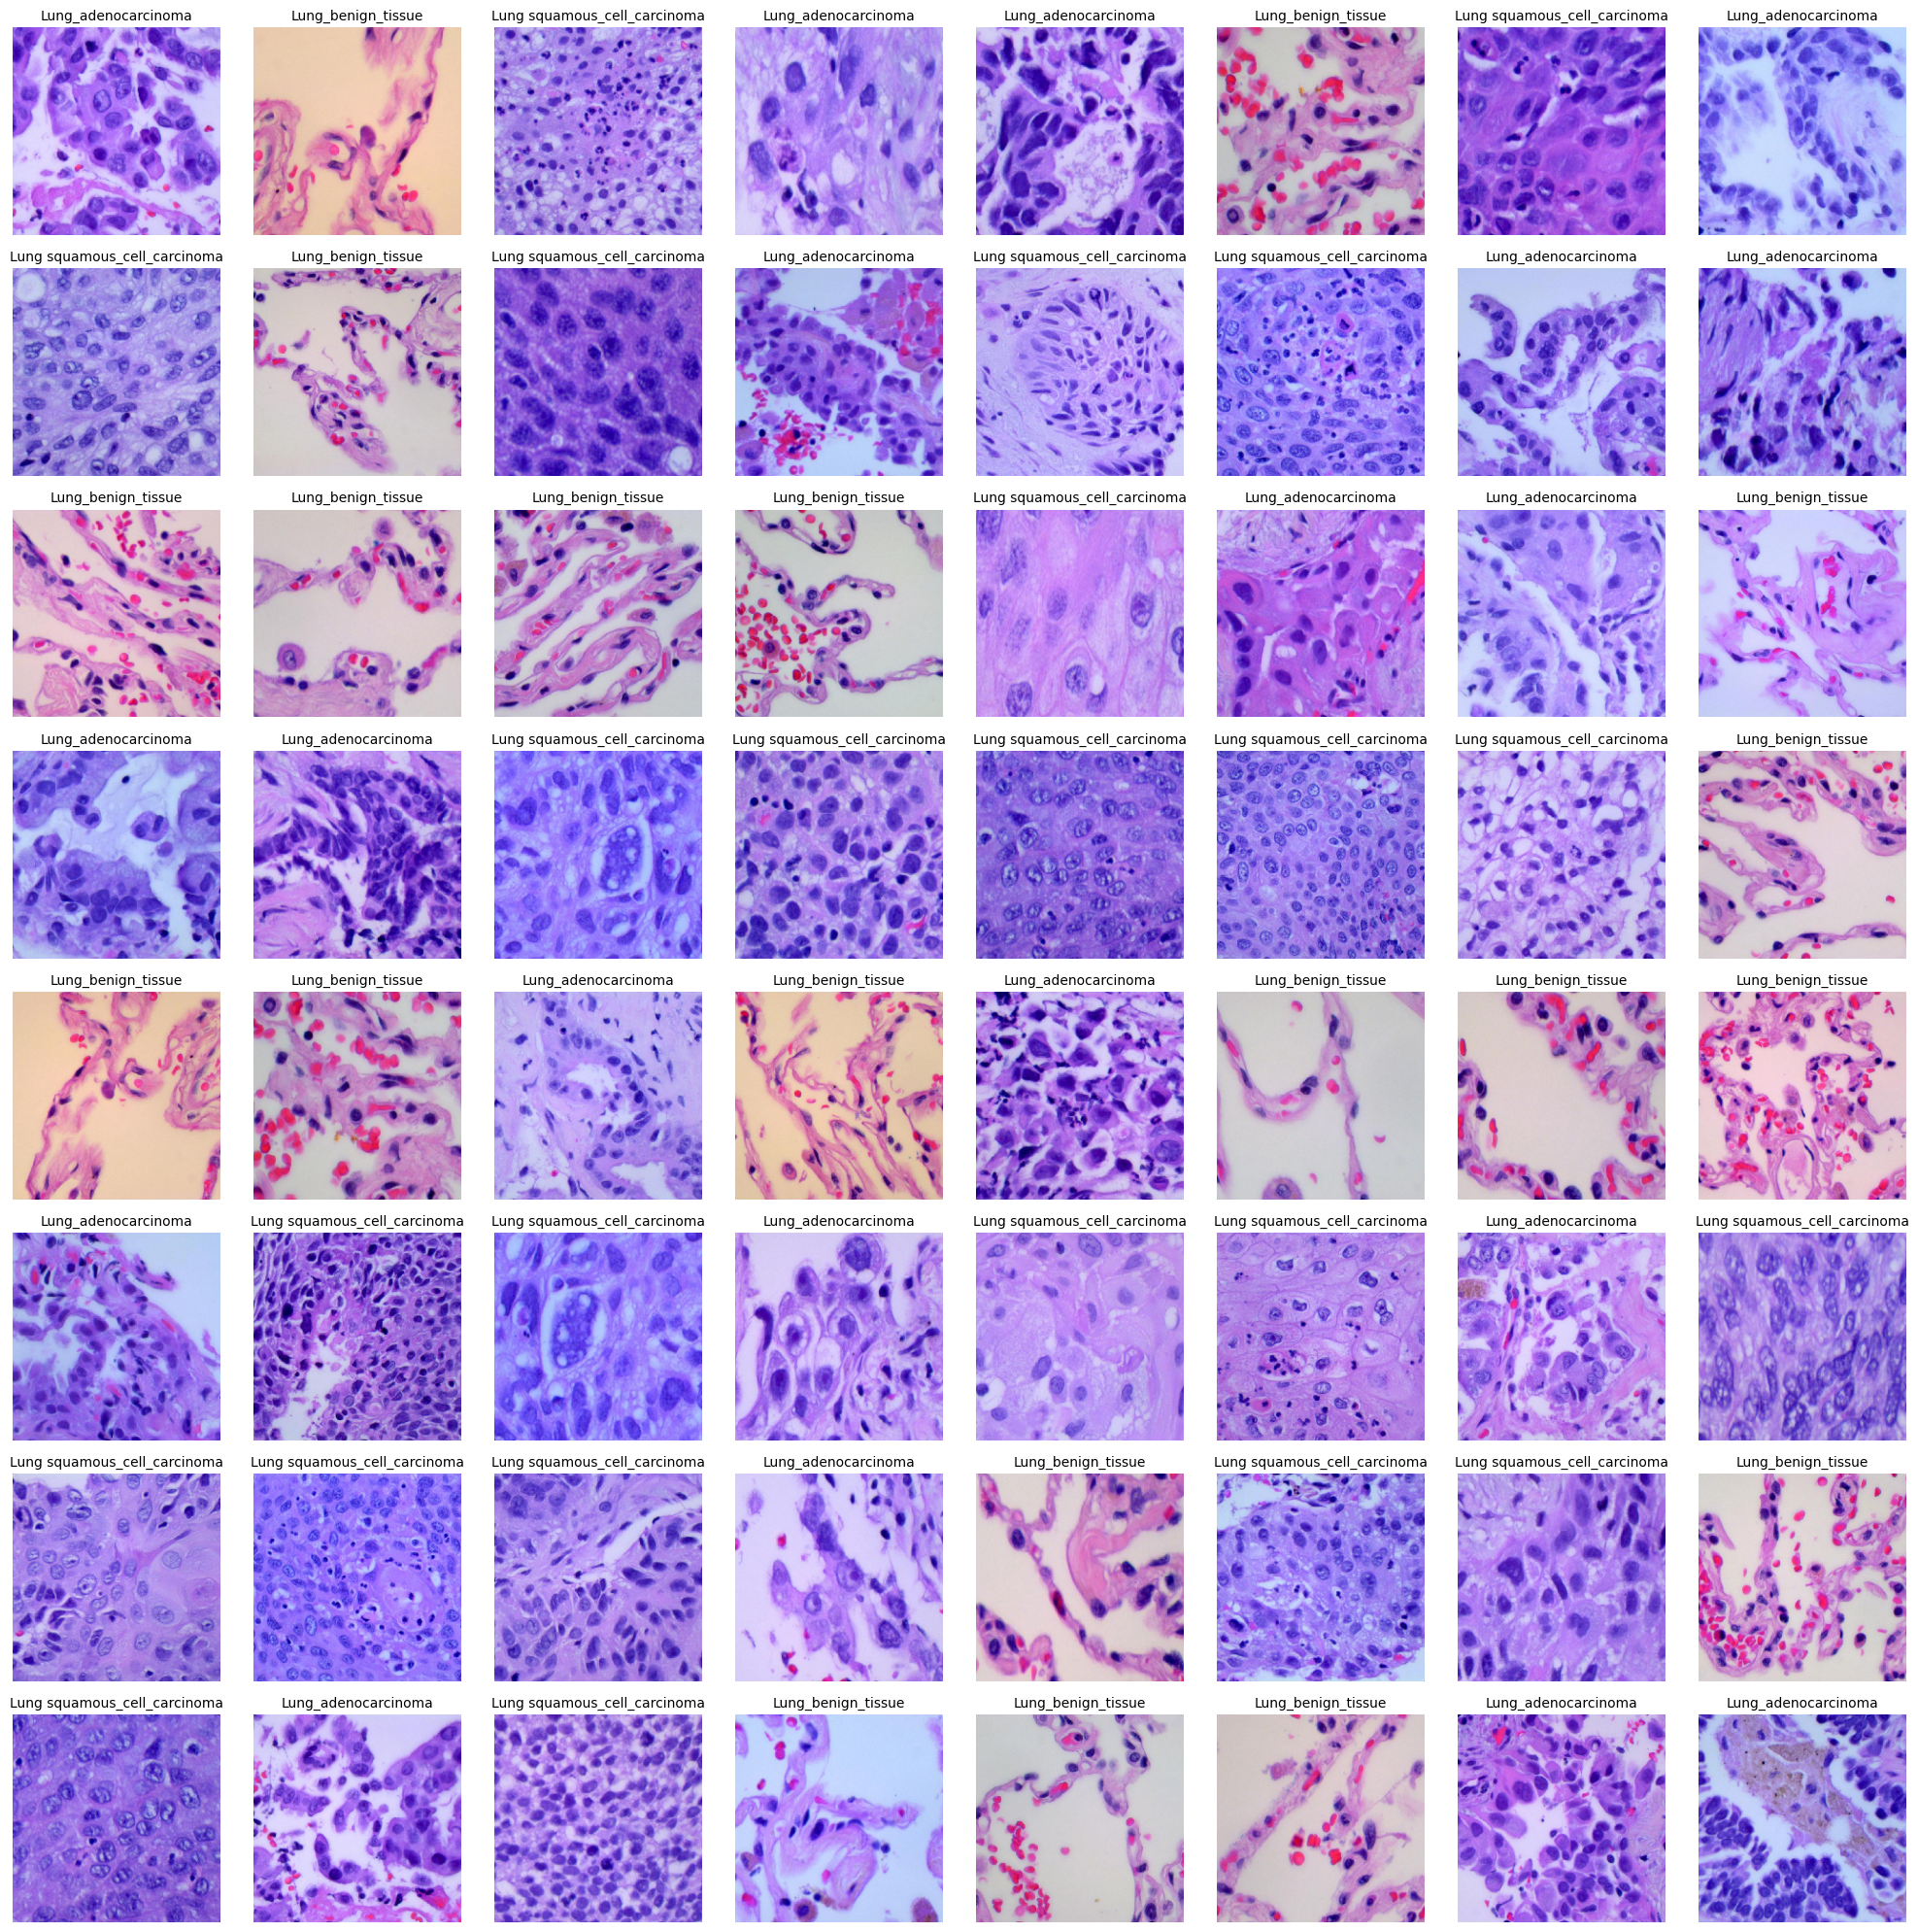

In [ ]:
# Retrieving class indices and visualizing a batch of images and labels
class_indices = train_gen.class_indices
classes = list(class_indices.keys())
images, labels = next(train_gen)
plt.figure(figsize=(20, 20))
for i in range(min(batch_size, len(images))):
  plt.subplot(8, 8, i + 1)
  if images[i].max() > 1:
    img_to_show = images[i].astype('uint8')
  else:
    img_to_show = images[i]
  plt.imshow(img_to_show)
  class_index = np.argmax(labels[i])
  class_name = classes[class_index]
  plt.title(class_name, color='black', fontsize=10)
  plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Defining the Convolutional Neural Network (CNN) model architecture
# Using Sequential API to stack layers like Conv2D, MaxPooling, Flatten, and Dense layers
input_shape=[224, 224, 3]
model = Sequential([
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu", input_shape=input_shape),
    Conv2D(filters=64, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256,activation = "relu"),
    Dense(64,activation = "relu"),
    Dense(3, activation = "softmax")
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 33,342,275 (127.19 MB)

 Trainable params: 33,342,275 (127.19 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Training the model with the specified number of epochs and batch size
# Using validation data to monitor the model's performance during training
epochs = 10
history = model.fit(train_gen, epochs= epochs, verbose= 1, validation_data=valid_gen , shuffle= False)

Epoch 1/10


I0000 00:00:1726628106.483741      72 service.cc:145] XLA service 0x78681c003a30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1726628106.483850      72 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1726628106.483858      72 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1726628169.694854      72 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.6605 - loss: 24.4009 - val_accuracy: 0.9187 - val_loss: 0.2030
Epoch 2/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 764ms/step - accuracy: 0.9003 - loss: 0.2460 - val_accuracy: 0.9367 - val_loss: 0.1547
Epoch 3/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 765ms/step - accuracy: 0.9214 - loss: 0.1958 - val_accuracy: 0.9460 - val_loss: 0.1320
Epoch 4/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 144s 765ms/step - accuracy: 0.9398 - loss: 0.1591 - val_accuracy: 0.9427 - val_loss: 0.1415
Epoch 5/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 145s 768ms/step - accuracy: 0.9546 - loss: 0.1160 - val_accuracy: 0.9607 - val_loss: 0.1068
Epoch 6/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 145s 769ms/step - accuracy: 0.9600 - loss: 0.1064 - val_accuracy: 0.9527 - val_loss: 0.1086
Epoch 7/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 145s 769ms/step - accuracy: 0.9676 - loss: 0.0718 - val_accuracy: 0.9740 - val_loss: 0.0838
Epoch 8/10
188/188 ━━━━━━━━━━━━━━━━━━━━ 145s 772ms/step - accuracy: 0.9820 - loss: 0.0518

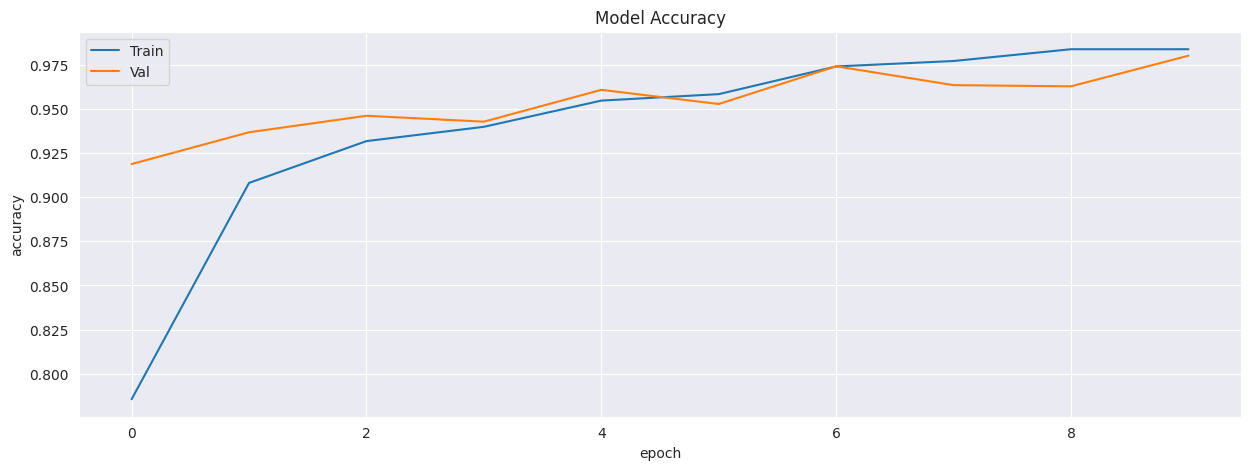

In [ ]:
# Plotting training and validation accuracy to visualize the model's performance
plt.figure(figsize=(15,5))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

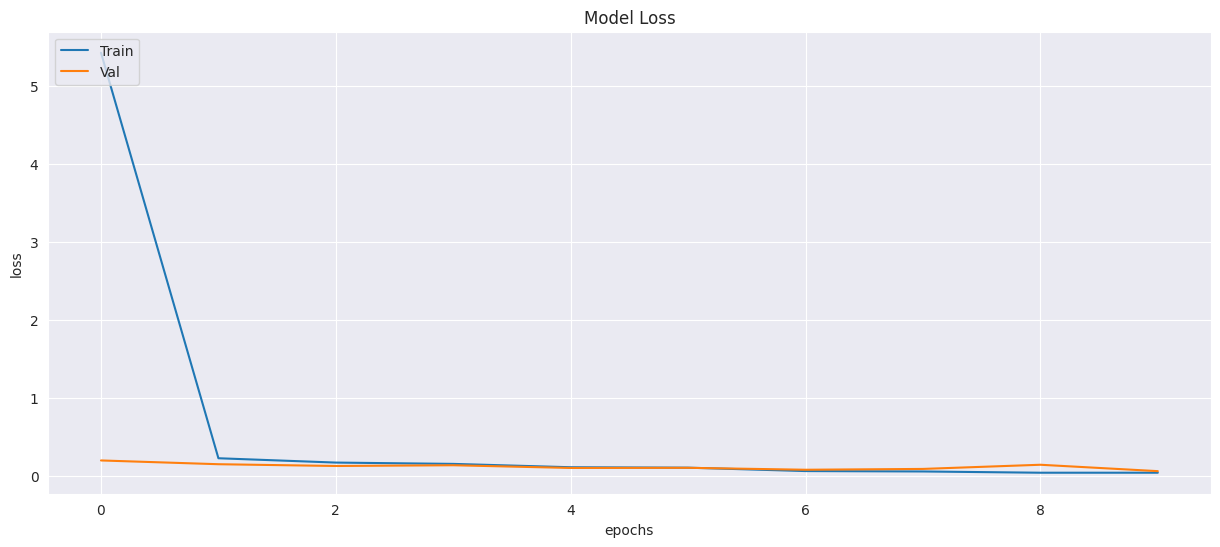

In [ ]:
# Plotting training and validation loss to visualize how well the model is learning
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['Train','Val'], loc= 'upper left')
plt.show()

In [ ]:
# Evaluating the model's performance on the training and validation sets
train_score = model.evaluate(train_gen, verbose= 1)
valid_score = model.evaluate(valid_gen, verbose= 1)
test_score = model.evaluate(test_gen, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

188/188 ━━━━━━━━━━━━━━━━━━━━ 67s 355ms/step - accuracy: 0.9941 - loss: 0.0202
24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 334ms/step - accuracy: 0.9804 - loss: 0.0609
24/24 ━━━━━━━━━━━━━━━━━━━━ 15s 614ms/step - accuracy: 0.9811 - loss: 0.0716
Train Loss:  0.019393743947148323
Train Accuracy:  0.9950000047683716
--------------------
Validation Loss:  0.06595500558614731
Validation Accuracy:  0.9800000190734863
--------------------
Test Loss:  0.07839236408472061
Test Accuracy:  0.9779999852180481


In [ ]:
# Making predictions on the test set
preds = model.predict(test_gen)
y_pred = np.argmax(preds, axis=1)

24/24 ━━━━━━━━━━━━━━━━━━━━ 8s 325ms/step


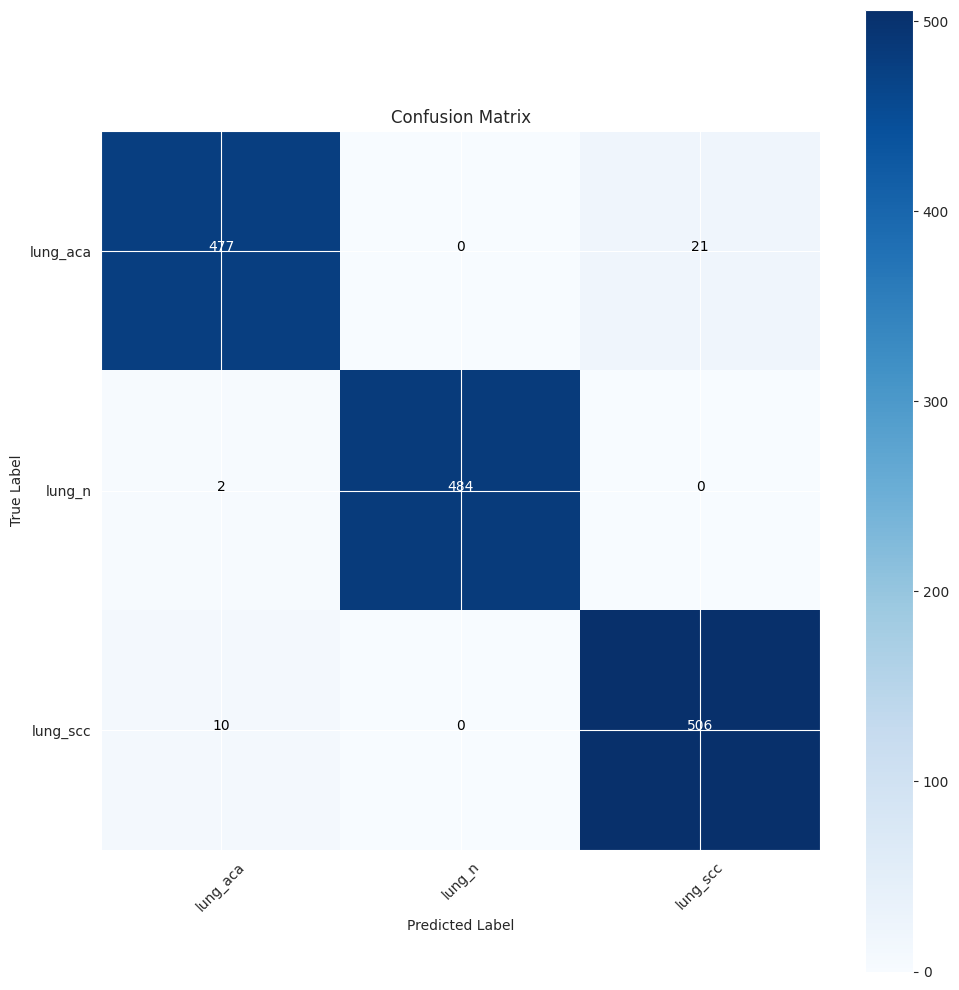

In [ ]:
# Creating a confusion matrix to evaluate the performance of the classification
# Visualizing it to better understand the number of correct and incorrect predictions
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [ ]:
# Printing a detailed classification report including precision, recall, and F1-score for each class
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

    lung_aca       0.98      0.96      0.97       498
      lung_n       1.00      1.00      1.00       486
    lung_scc       0.96      0.98      0.97       516

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500

